In [186]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set_theme(style="darkgrid", palette="pastel")
sns.set(rc={'figure.figsize':(10,10)})
from scipy.stats import ttest_ind

# Background and Data Source

The analyzed data is stems from the Home Mortgage Disclosure Act and provides data on mortgage applications New York.

>The Home Mortgage Disclosure Act (or HMDA, pronounced HUM-duh) is a United States federal law that requires certain financial institutions to provide mortgage data to the public. Congress enacted HMDA in 1975.[1]

https://en.wikipedia.org/wiki/Home_Mortgage_Disclosure_Act

# Objective
This notebooks objective is to explore the available data and draw conclusions about it.


# Explorational Data Analysis

In [98]:
df = pd.read_csv("sample.csv")

In [99]:
df.head()

,action_taken_name,agency_name,applicant_ethnicity_name,applicant_race_name_1,applicant_sex_name,applicant_income_000s,co_applicant_ethnicity_name,co_applicant_race_name_1,co_applicant_sex_name,county_name,...,owner_occupancy_name,preapproval_name,property_type_name,purchaser_type_name,hud_median_family_income,loan_amount_000s,number_of_1_to_4_family_units,number_of_owner_occupied_units,minority_population,population
0,Application denied by financial institution,Consumer Financial Protection Bureau,Not Hispanic or Latino,White,Female,176.0,No co-applicant,No co-applicant,No co-applicant,Chautauqua County,...,Not owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,60000.0,235,2605.0,930.0,6.850000,2979.0
1,Application withdrawn by applicant,Department of Housing and Urban Development,Not Hispanic or Latino,White,Male,53.0,No co-applicant,No co-applicant,No co-applicant,Erie County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,69000.0,108,2053.0,821.0,33.580002,4416.0
2,Loan originated,Consumer Financial Protection Bureau,Not Hispanic or Latino,White,Male,223.0,Not Hispanic or Latino,White,Female,Queens County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,71300.0,659,497.0,387.0,49.959999,1363.0
3,Loan originated,Consumer Financial Protection Bureau,Not Hispanic or Latino,Asian,Female,43.0,No co-applicant,No co-applicant,No co-applicant,Queens County,...,Owner-occupied as a principal dwelling,Not applicable,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,71300.0,103,251.0,558.0,32.090000,1960.0
4,Loan originated,National Credit Union Administration,Not Hispanic or Latino,White,Male,72.0,No co-applicant,No co-applicant,No co-applicant,Steuben County,...,Owner-occupied as a principal dwelling,Preapproval was requested,One-to-four family dwelling (other than manufa...,Loan was not originated or was not sold in cal...,60000.0,45,1514.0,1003.0,2.120000,3391.0


In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110314 entries, 0 to 175861
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   action_taken_name               110314 non-null  object 
 1   agency_name                     110314 non-null  object 
 2   applicant_ethnicity_name        110314 non-null  object 
 3   applicant_race_name_1           110314 non-null  object 
 4   applicant_sex_name              110314 non-null  object 
 5   applicant_income_000s           104391 non-null  float64
 6   co_applicant_ethnicity_name     110314 non-null  object 
 7   co_applicant_race_name_1        110314 non-null  object 
 8   co_applicant_sex_name           110314 non-null  object 
 9   county_name                     110079 non-null  object 
 10  denial_reason_name_1            18840 non-null   object 
 11  denial_reason_name_2            3921 non-null    object 
 12  denial_reason_na

# How many loans are sucessfull?

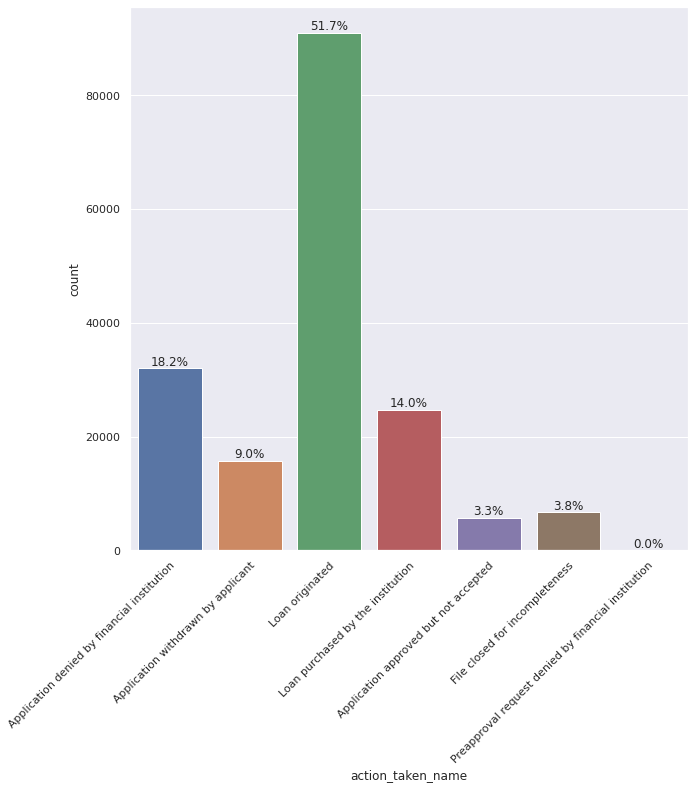

In [101]:
ax = sns.countplot(x='action_taken_name', data=df)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/df.action_taken_name.count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge')

plt.show()


We can observe, that ca. 52% of loan applications are successfull.

In the further analyse I will focus on the relationships
Therefore, we will group the action taken and drop loans purchased on the secondary market, incomplete and withdrawn applications:

In [102]:
#Group applications based on the actions taken
def group_actions(name):
    denied = ['Application denied by financial institution','Preapproval request denied by financial institution']
    approved = ['Loan originated','Application approved but not accepted']
    if name in approved:
        return 'approved'
    elif name in denied:
        return 'denied'
    else:
        return None
    
df['application_result_group'] = df['action_taken_name'].apply(group_actions)
df = df[df['application_result_group'].notna()]

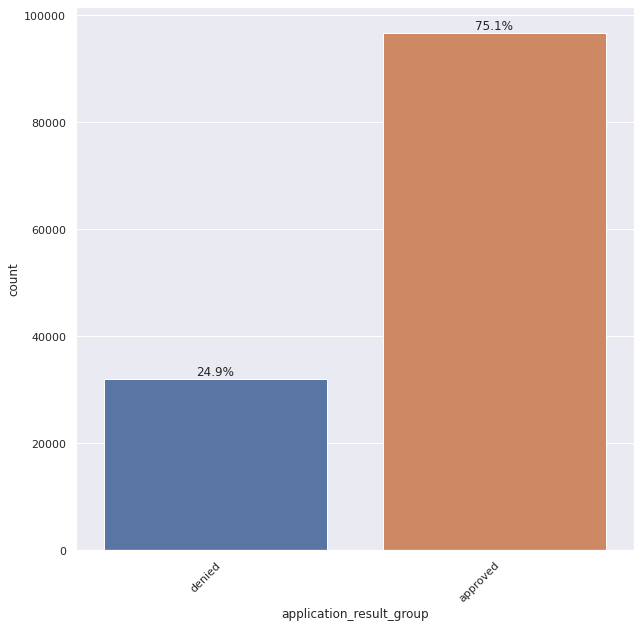

In [103]:
ax = sns.countplot(x='application_result_group', data=df)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/df.application_result_group.count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge')

plt.show()


# How are the Loans characterized?

We can observe differences in income distributions and approval ratings between the gender, race and ethnicity groups.
- As expected by the generell difference in income distributions between the accepted and denied group, we can observe the same trend when further dissecting the applicants by their race, gender and ethnicity data.
- Although trends in income distribution for the different racegroups seem to correspond with the approval ratings, the Asian group seems to break this trend by having the highest average income, but only the second highest approval rating
- Although the income discrepancy between Male and Female Applicants is rather large (146k  vs 102k), we only observe a 2% difference in approval rating


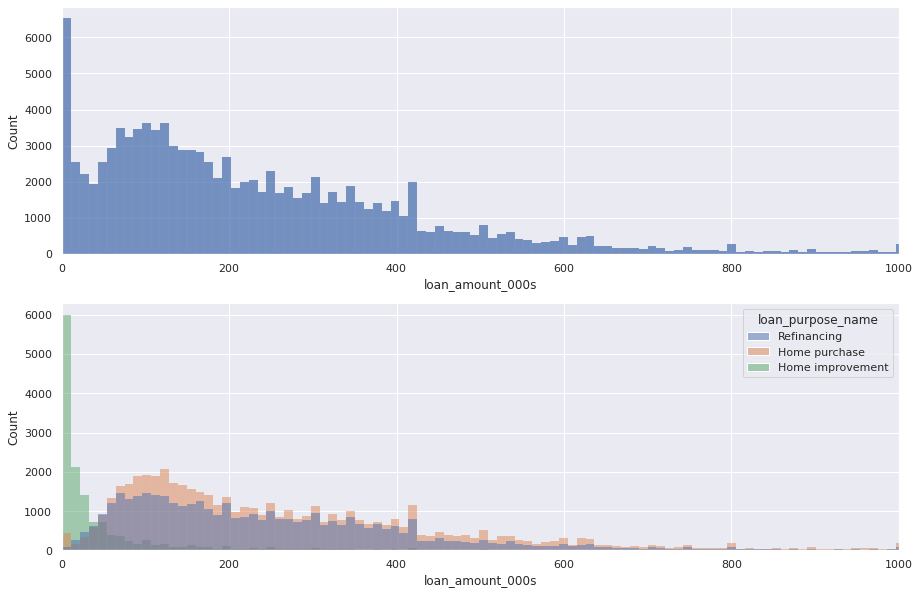

In [195]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(2,1,1)
sns.histplot(data=df,x="loan_amount_000s",ax=ax1)
plt.xlim(0,1000)
ax2 = fig.add_subplot(2,1,2)

sns.histplot(data=df,x="loan_amount_000s",hue="loan_purpose_name",ax=ax2)
plt.xlim(0,1000)


plt.show()


When looking at the distribution of loan amount, we can observe a spike for lower amounts < 30k.
By splitting the dataset by the loan purpose type we see a clear difference in loan amounts, especially between Home Improvement Loans and Refinancing/Home purchase loans

- The Average loan amount is 269k
- The Average Home purchase or Refinancing loan is 299k  while the average home improvement loan is 68,92k  with a median of just 18k



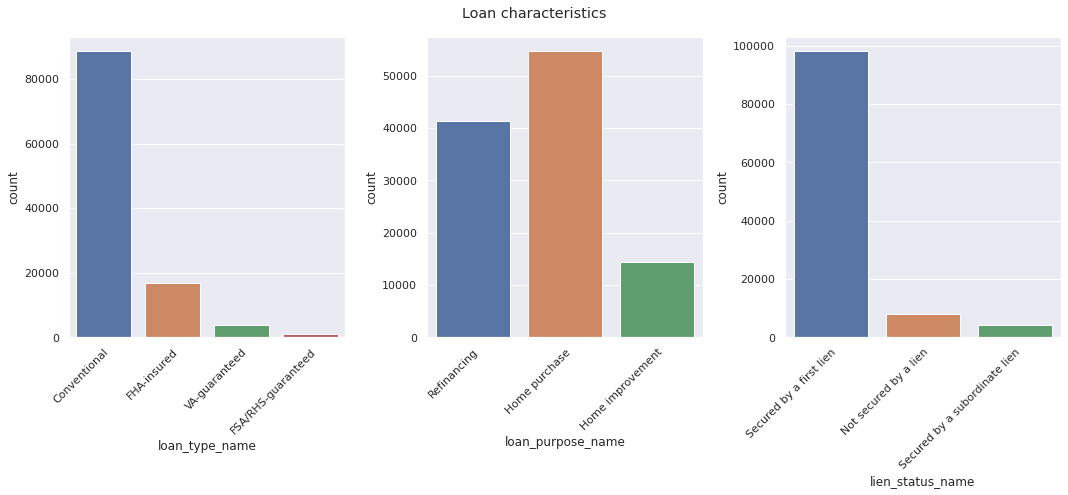

In [116]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Loan characteristics') # or plt.suptitle('Main title')
ax1 = fig.add_subplot(1,3,1)
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

sns.countplot(data=df,x="loan_type_name",ax=ax1)
ax2 = fig.add_subplot(1,3,2)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

sns.countplot(data=df,x="loan_purpose_name",ax=ax2)
ax3 = fig.add_subplot(1,3,3)
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

sns.countplot(data=df,x="lien_status_name",ax=ax3)
plt.tight_layout()

- Most loans are conventional
- Refinancing and Home purchase loans make up the majority of the dataset
- Most loans are secured by a first lien

## Are loan characteristics correlated with the success of a loan application?

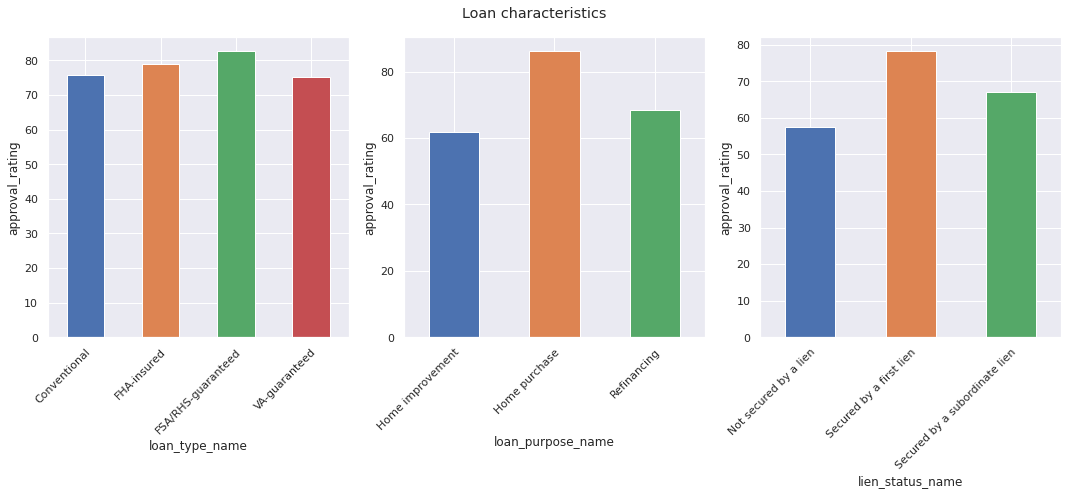

In [194]:
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Loan characteristics') # or plt.suptitle('Main title')
ax1 = fig.add_subplot(1,3,1)

ct = pd.crosstab(df["application_result_group"], df['loan_type_name'],normalize='columns').loc["approved",:]*100
ct.plot(kind="bar",color=['C0', 'C1', 'C2','C3'],ax=ax1)
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.ylabel("approval_rating")


ax2 = fig.add_subplot(1,3,2)
ct = pd.crosstab(df["application_result_group"], df['loan_purpose_name'],normalize='columns').loc["approved",:]*100
ct.plot(kind="bar",color=['C0', 'C1', 'C2'],ax=ax2)
plt.ylabel("approval_rating")
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax3 = fig.add_subplot(1,3,3)

ct = pd.crosstab(df["application_result_group"], df['lien_status_name'],normalize='columns').loc["approved",:]*100
ct.plot(kind="bar",color=['C0', 'C1', 'C2'],ax=ax3)
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.ylabel("approval_rating")
plt.tight_layout()
plt.show()


In [223]:
pd.crosstab(df["application_result_group"], df['lien_status_name'],normalize='columns').loc["approved",:]*100

lien_status_name
Not secured by a lien            57.582306
Secured by a first lien          78.241463
Secured by a subordinate lien    67.060185
Name: approved, dtype: float64

- FHA-insured and FSA/RHS-guaranteed loans have an above average approval ratio
- Home purchase loans have the highest approval ratio among the purpose groups at 86% 
- Home Improvement loans only have a ~62 % approval ratio

- Loans secured by a first lien have the highest approval rating

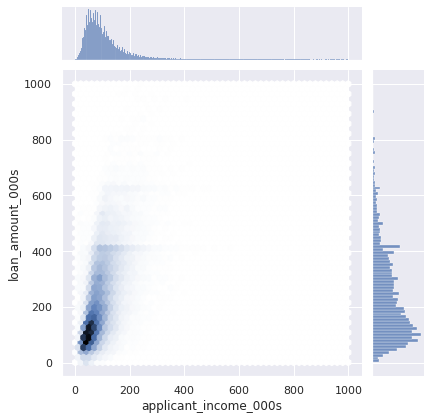

In [201]:
temp_df = df.loc[df["loan_amount_000s"]<1000]
temp_df = temp_df.loc[df["loan_purpose_name"]!="Home improvement"]
temp_df = temp_df.loc[df["applicant_income_000s"]<1000]

g=sns.jointplot(data=temp_df, y="loan_amount_000s",x = "applicant_income_000s", kind="hex")
plt.show()

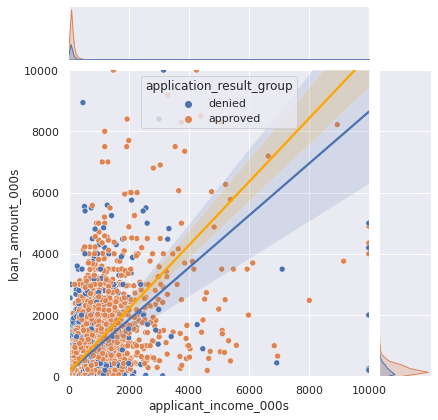

In [219]:
g=sns.jointplot(data=df, y="loan_amount_000s",x = "applicant_income_000s",hue="application_result_group")
g.ax_joint.set_xlim(0,10000)
g.ax_joint.set_ylim(0,10000)
sns.regplot(ax=g.ax_joint,x=df.loc[df["application_result_group"]=="denied","applicant_income_000s"],y=df.loc[df["application_result_group"]=="denied","loan_amount_000s"],scatter=False)
sns.regplot(ax=g.ax_joint,x=df.loc[df["application_result_group"]=="approved","applicant_income_000s"],y=df.loc[df["application_result_group"]=="approved","loan_amount_000s"],scatter=False,color="orange")


plt.show()

# Who is applying for Loans?

In [104]:
#Lets first start by cleaning up the relevant columns and only keep rows which have relevant data
df.loc[df["applicant_sex_name"]=='Information not provided by applicant in mail, Internet, or telephone application',"applicant_sex_name"] = None 
df.loc[df["applicant_ethnicity_name"]=='Information not provided by applicant in mail, Internet, or telephone application',"applicant_ethnicity_name"] = None 
df.loc[df["applicant_race_name_1"]=='Information not provided by applicant in mail, Internet, or telephone application',"applicant_race_name_1"] = None 

df.loc[df["applicant_sex_name"]=='Not applicable',"applicant_sex_name"] = None 
df.loc[df["applicant_ethnicity_name"]=='Not applicable',"applicant_ethnicity_name"] = None 
df.loc[df["applicant_race_name_1"]=='Not applicable',"applicant_race_name_1"] = None 

df.dropna(subset=["applicant_sex_name","applicant_ethnicity_name","applicant_race_name_1"],inplace=True)

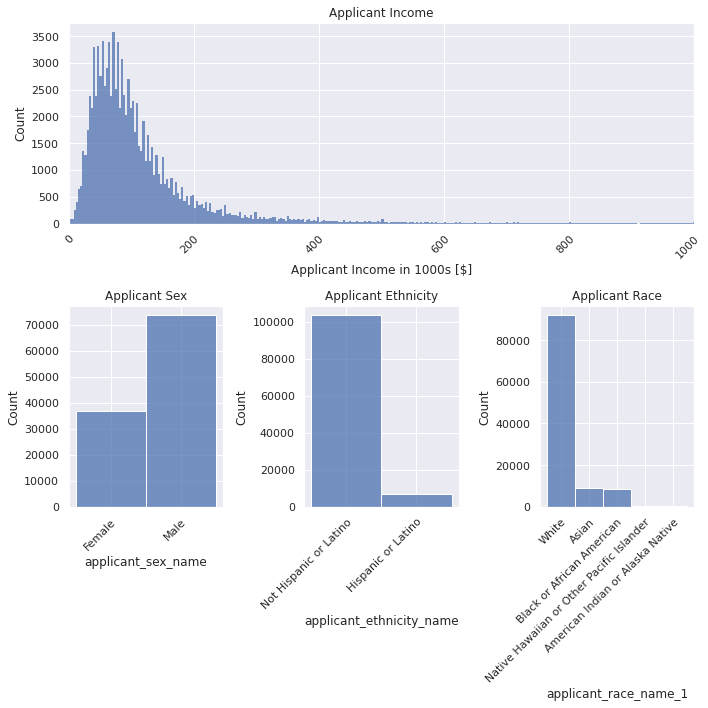

In [105]:
fig = plt.figure(figsize=(10, 10))

plt.subplots_adjust(wspace= 0.25, hspace= 0.25)

sub1 = fig.add_subplot(2,3,4) # two rows, two columns, fist cell
plt.setp(sub1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
hist = sns.histplot(df,x="applicant_sex_name",ax=sub1)
sub1.set_title("Applicant Sex")

sub2 = fig.add_subplot(2,3,5) # two rows, two columns, second cell
hist = sns.histplot(df,x="applicant_ethnicity_name",ax=sub2)
sub2.set_title("Applicant Ethnicity")

plt.setp(sub2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Create third axes, a combination of third and fourth cell
sub3 = fig.add_subplot(2,3,6) # two rows, two colums, combined third and fourth cell
plt.setp(sub3.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
hist = sns.histplot(df,x="applicant_race_name_1",ax=sub3)
sub3.set_title("Applicant Race")

#fig.tight_layout()
sub4 = fig.add_subplot(2,3,(1,3)) # two rows, two colums, combined third and fourth cell
col = "applicant_income_000s"
sns.histplot(df,x=col,ax=sub4)
sub4.set_xlabel("Applicant Income in 1000s [$]")
sub4.set_xlim(0,1000)
plt.setp(sub4.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

sub4.set_title("Applicant Income")
plt.tight_layout()

plt.show()

In [239]:
df.applicant_income_000s.median()

87.0

- The mean income is 132k, median 87k 

- There are about twice as many men applying for loans compared to women
- applications from people with Hispanic opr Latino ethnicity make up only ~6 % of the dataset
- majority of applicants are White (83 %), Asian 8%, 8% Black or African American, American Indian or Alaska Native <1 %, Native Hawaiian or Other Pacific Islander <1 %


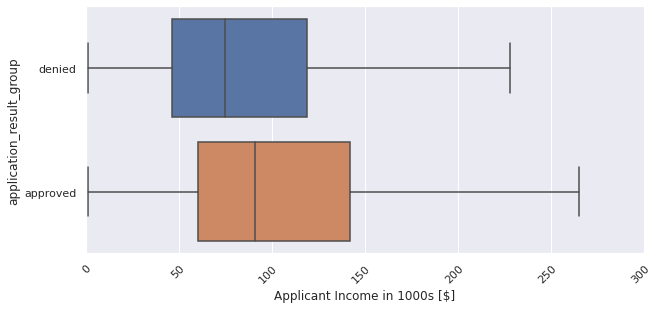

In [113]:
fig = plt.figure(figsize=(10, 10))
sub4 = fig.add_subplot(2,3,(1,3)) # two rows, two colums, combined third and fourth cell
col = "applicant_income_000s"
sns.boxplot(data=df,orient="h",x=col,y="application_result_group",showfliers=False ,ax=sub4)
sub4.set_xlabel("Applicant Income in 1000s [$]")
sub4.set_xlim(0,300)
plt.setp(sub4.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

- We can observe a trend of higher incomes for the group of approved applications

In [240]:
#Normalize Approval Ratios within each group

temp_df = df.groupby(['applicant_sex_name', 'application_result_group']).agg({'application_result_group': 'count'})
temp_df= temp_df.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
approval_ratio_sex = pd.DataFrame(columns=["Applicant_Sex","Approval_Ratio"])
approval_ratio_sex.Applicant_Sex = ["Female","Male"]

approval_ratio_sex.Approval_Ratio = [temp_df.loc["Female","approved"].tolist()[0],temp_df.loc["Male","approved"].tolist()[0]]


temp_df = df.groupby(['applicant_ethnicity_name', 'application_result_group']).agg({'application_result_group': 'count'})
temp_df= temp_df.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
approval_ratio_ethnicity = pd.DataFrame(columns=["Applicant_Ethnicity'","Approval_Ratio"])
approval_ratio_ethnicity["Applicant_Ethnicity"] = ["Not Hispanic or Latino","Hispanic or Latino"]

approval_ratio_ethnicity["Approval_Ratio"] = [temp_df.loc["Not Hispanic or Latino","approved"].tolist()[0],temp_df.loc["Hispanic or Latino","approved"].tolist()[0]]

temp_df = df.groupby(['applicant_race_name_1', 'application_result_group']).agg({'application_result_group': 'count'})
temp_df= temp_df.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
race_list = df.applicant_race_name_1.unique().tolist()
approval_ratio_race = pd.DataFrame(columns=["Applicant_Race","Approval_Ratio"])
approval_ratio_race["Applicant_Race"] = race_list

for r in race_list:
    approval_ratio_race.loc[approval_ratio_race["Applicant_Race"]==r,"Approval_Ratio"] = temp_df.loc[r,"approved"].tolist()[0]



# Relationships between Application Result, Income and Applicant Characteristics.

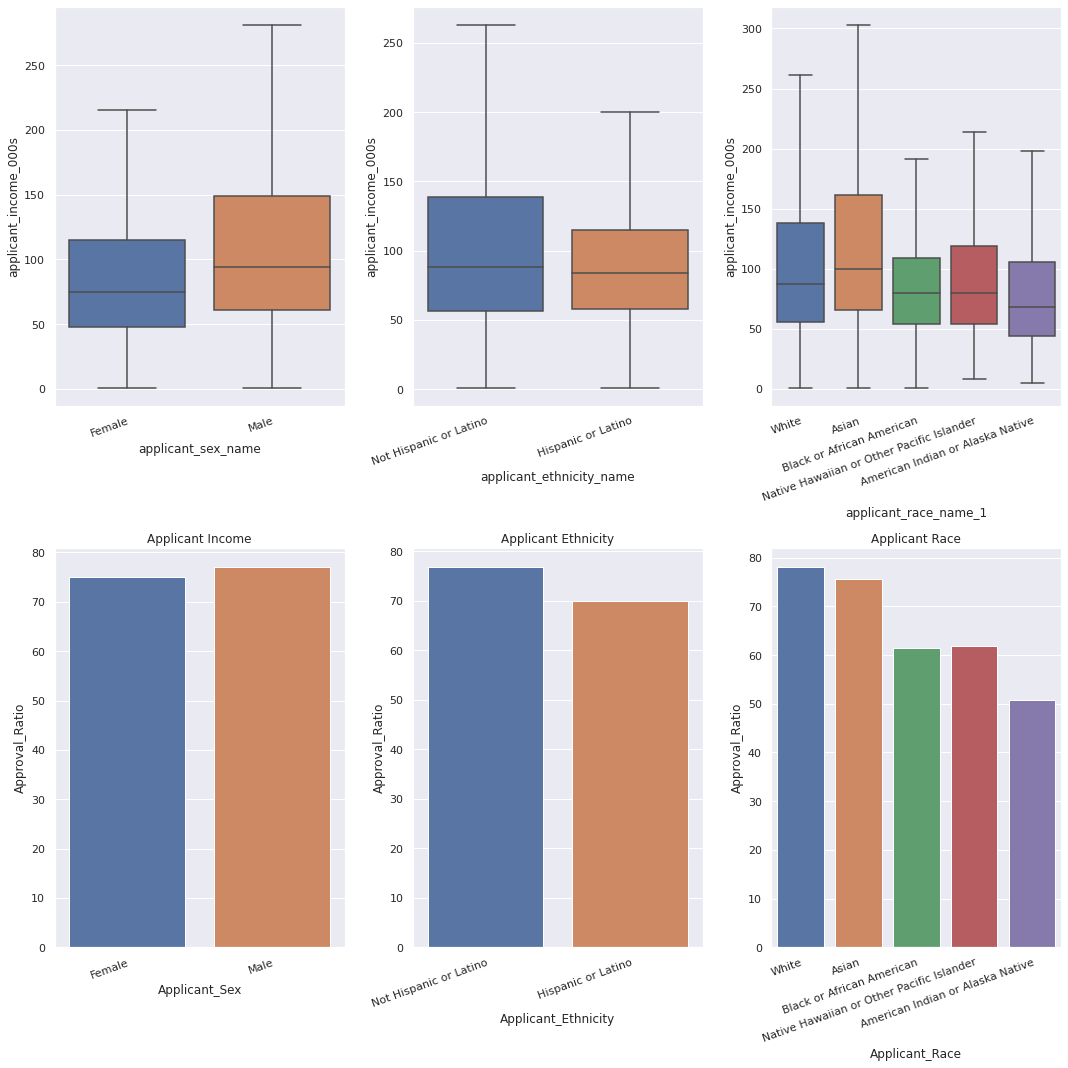

In [109]:
fig = plt.figure(figsize=(15,15))

plt.subplots_adjust(wspace= 0.25, hspace= 0.25)

sub4 = fig.add_subplot(2,3,4) # two rows, two columns, fist cell
plt.setp(sub4.get_xticklabels(), rotation=20, ha="right", rotation_mode="anchor")
hist = sns.barplot(data=approval_ratio_sex,x="Applicant_Sex",y="Approval_Ratio",ax=sub4)
sub4.set_title("Applicant Sex")

sub5 = fig.add_subplot(2,3,5) # two rows, two columns, second cell
hist = sns.barplot(data=approval_ratio_ethnicity,x="Applicant_Ethnicity",y="Approval_Ratio",ax=sub5)
sub5.set_title("Applicant Ethnicity")

plt.setp(sub5.get_xticklabels(), rotation=20, ha="right", rotation_mode="anchor")
# Create third axes, a combination of third and fourth cell
sub6 = fig.add_subplot(2,3,6) # two rows, two colums, combined third and fourth cell
plt.setp(sub6.get_xticklabels(), rotation=20, ha="right", rotation_mode="anchor")
hist = sns.barplot(data=approval_ratio_race,x="Applicant_Race",y="Approval_Ratio",ax=sub6)
sub6.set_title("Applicant Race")

sub4.set_title("Applicant Income")




sub1 = fig.add_subplot(2,3,1) # two rows, two colums, combined third and fourth cell
sns.boxplot(data=df,orient="v",y="applicant_income_000s",x="applicant_sex_name",showfliers=False ,ax=sub1)
plt.setp(sub1.get_xticklabels(), rotation=20, ha="right", rotation_mode="anchor")

sub2 = fig.add_subplot(2,3,3) # two rows, two colums, combined third and fourth cell
sns.boxplot(data=df,orient="v",y="applicant_income_000s",x="applicant_race_name_1",showfliers=False ,ax=sub2)
plt.setp(sub2.get_xticklabels(), rotation=20, ha="right", rotation_mode="anchor")

sub3 = fig.add_subplot(2,3,2) # two rows, two colums, combined third and fourth cell
sns.boxplot(data=df,orient="v",y="applicant_income_000s",x="applicant_ethnicity_name",showfliers=False ,ax=sub3)
plt.setp(sub3.get_xticklabels(), rotation=20, ha="right", rotation_mode="anchor")


plt.tight_layout()

plt.show()

# Approval Rating by county

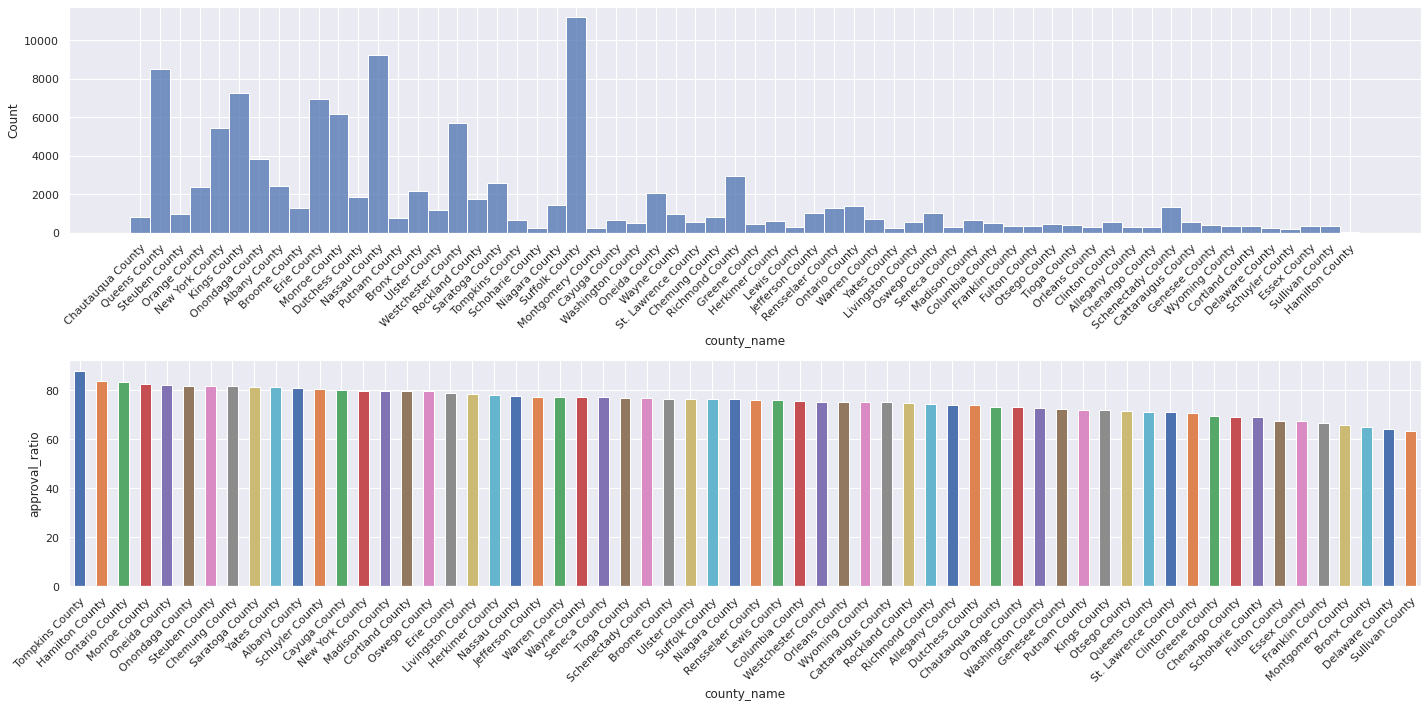

In [285]:
fig = plt.figure(figsize=(20, 10))

ax0 = fig.add_subplot(2,1,1)

sns.histplot(df,x="county_name",ax=ax0)
plt.setp(ax0.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


ax1 = fig.add_subplot(2,1,2)

ct = pd.crosstab(df["application_result_group"], df['county_name'],normalize='columns').loc["approved",:]*100
ct.sort_values(ascending=False).plot(kind="bar",color=["C"+str(i) for i in range(len(ct))],ax=ax1)
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.ylabel("approval_ratio")
plt.show()

- Tompkins County has the highest approval ratio, Sullivan County the lowest

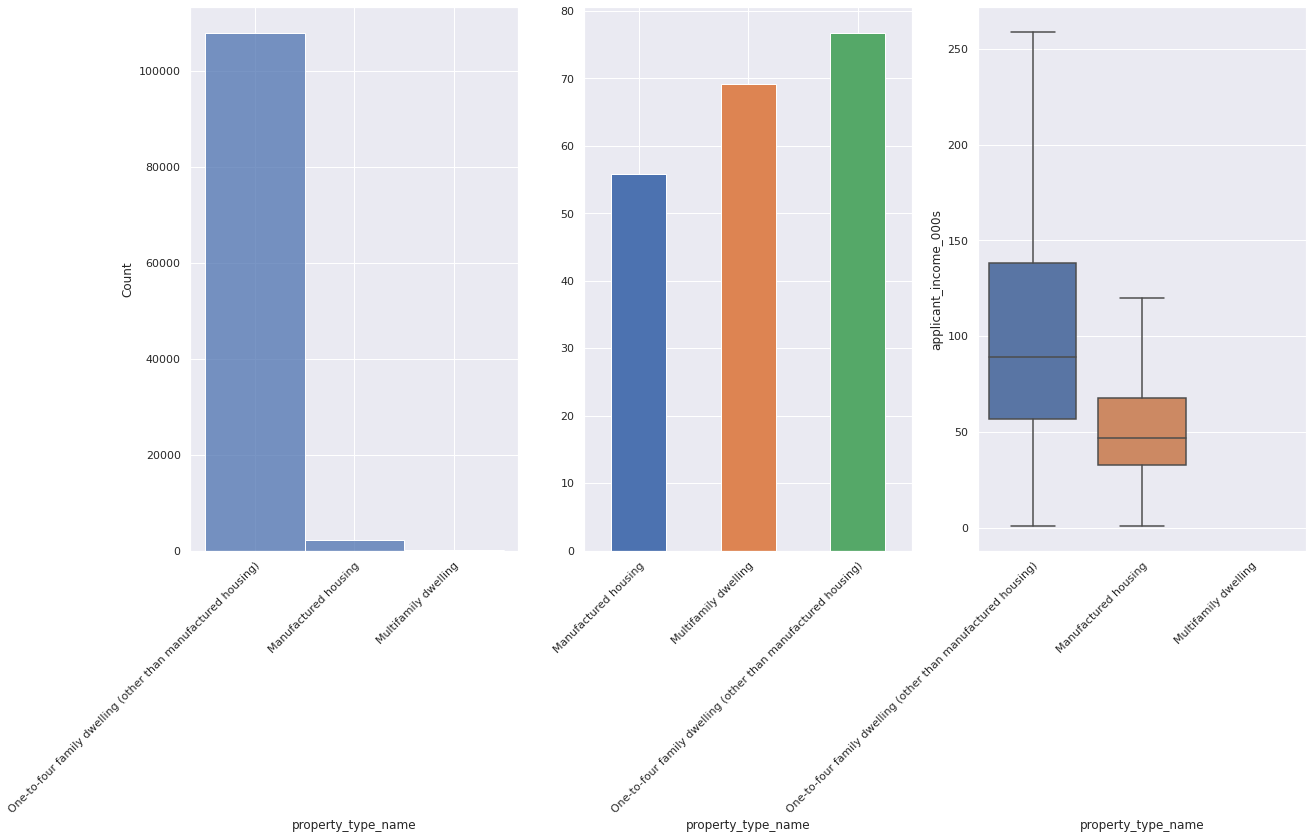

In [276]:
fig = plt.figure(figsize=(20, 10))

ax0 = fig.add_subplot(1,3,1)
sns.histplot(data=df,x="property_type_name",ax=ax0)
plt.setp(ax0.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax1 = fig.add_subplot(1,3,2)
ct = pd.crosstab(df["application_result_group"], df['property_type_name'],normalize='columns').loc["approved",:]*100
ct.plot(kind="bar",color=['C0', 'C1', 'C2'],ax=ax1)
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax2 = fig.add_subplot(1,3,3)
sns.boxplot(data=df,orient="v",y="applicant_income_000s",x="property_type_name",showfliers=False ,ax=ax2)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

- The majority of loan application are for One-to-four family dwellings
- Manufactured Homes have a significantly lower income distribution among their applicants, which is also apparent in the approval rating

# What are the reasons for the denial of applications?


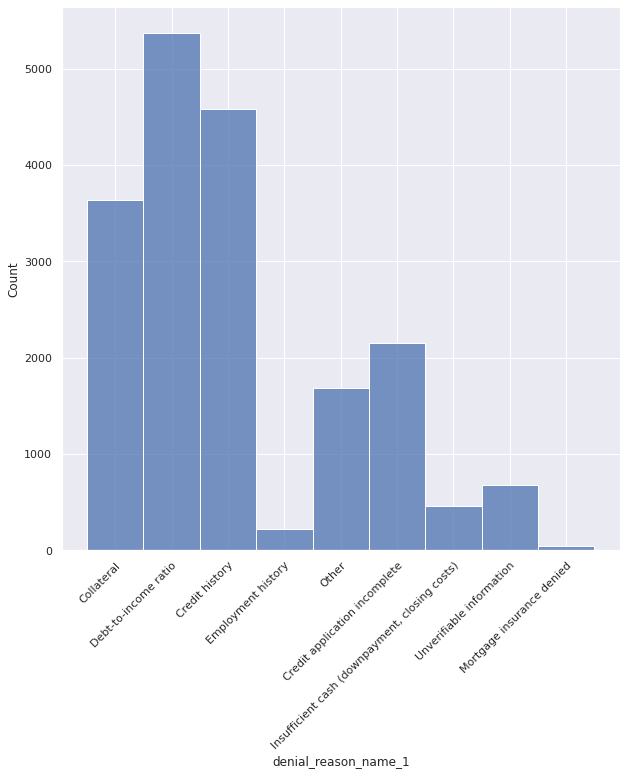

In [283]:

ax1=sns.histplot(df,x="denial_reason_name_1")
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.show()

In [ ]:
- The top three reasons for the denial of an applications are the Collateral, Debt-to-income ratio and the Credit History

# Summary

The analyzed dataset contains data on 175862 loan applications for the state of New York.
We can observe, that ca. 52% of loan applications are originated. 
After grouping the action taken on application and dropping incomplete withdrawn applications and loans bought on the secondary market, we have a split of 75% approved loans vs 25% denied loans.

## Loan Characteristics
When looking at the distribution of loan amount, we can observe a spike for lower amounts < 30k.
By splitting the dataset by the loan purpose type we see a clear difference in loan amounts, especially between Home Improvement Loans and Refinancing/Home purchase loans

- The Average loan amount is 269k $
- The Average Home purchase or Refinancing loan is 299k while the average home improvement loan is 68,92k $ with a median of just 18k $

- Most loans are conventional loans
- Refinancing and Home purchase loans make up the majority of the dataset
- Most loans are secured by a first lien

### Do Loan properties affect the chance of approval?
- FHA-insured and FSA/RHS-guaranteed loans have an above average approval ratio
- Home purchase loans have the highest approval ratio among the purpose groups at 86% 
- Home Improvement loans only have a ~62 % approval ratio

- Loans secured by a first lien have the highest approval rating

## Who is applying for loans?

- The mean income is 132k, median 87k 

- There are about twice as many men applying for loans compared to women
- applications from people with Hispanic opr Latino ethnicity make up only ~6 % of the dataset
- majority of applicants are White (83 %), Asian 8%, 8% Black or African American, American Indian or Alaska Native <1 %, Native Hawaiian or Other Pacific Islander <1 %

### Do applicant characteristics influence the chance of loan approval?
- We can observe a trend of higher incomes for the group of approved applications

We can observe differences in income distributions and approval ratings between the gender, race and ethnicity groups.

- As expected by the generell difference in income distributions between the accepted and denied group, we can observe the same trend when further dissecting the applicants by their race, gender and ethnicity data.
- Although trends in income distribution for the different racegroups seem to correspond with the approval ratings, the Asian group seems to break this trend by having the highest average income, but only the second highest approval rating
- Although the income discrepancy between Male and Female Applicants is rather large (146k vs 102k), we only observe a 2% difference in approval rating

## Are there any trends for property type or location?
- Tompkins County has the highest approval ratio, Sullivan County the lowest
- The majority of loan application are for One-to-four family dwellings
- Manufactured Homes have a significantly lower income distribution among their applicants, which is also apparent in the approval rating

# What are the reasons for the denial of applications?
- The top three reasons for the denial of an applications are the Collateral, Debt-to-income ratio and the Credit History

